# <div style="text-align: center; color: #1a5276;">Training</div>

## <font color='blue'>  Table of Contents </font>

1. [Introduction](#1)
2. [Setup](#2)
3. [Helper Functions](#3) 
4. [Data](#4) 
5. [Model](#5)
6. [Training](#6) <br>
    6.1. [Basic Training](#6.1) <br>
    6.2. [Including a progress bar](#6.2) <br>
    6.3. [Including a validation set](#6.3) <br>
    6.4. [Adding a custom metric](#6.4) <br>
7. [References](#references)

<a name="1"></a>
## <font color='blue'> 1. Introduction </font>

This notebook provides a step-by-step guide to building custom training loops in PyTorch. We'll cover essential elements like forward passes, loss computation, backpropagation, and parameter updates. The goal is to create a clear and reusable structure that can be adapted for various deep learning tasks.

<a name="2"></a>
## <font color='blue'> 2. Setup </font>

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import random
import torch.nn.functional as F

In [3]:
# seed
def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # For multi-GPU setups
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True  # Ensures deterministic behavior
    torch.backends.cudnn.benchmark = False      # Disables auto-tuning for convolutions (better reproducibility)

set_seed(42)


<a name="3"></a>
## <font color='blue'> 3. Helper Functions </font>

In [4]:
# Helper function for inline image display
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

        
# plot metrics
def plot_metrics(metrics):
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(metrics['train_loss'], label='Train Loss')
    plt.plot(metrics['val_loss'], label='Val Loss')
    plt.title('Loss Over Epochs')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(metrics['train_metric'], label='Train Metric')
    plt.plot(metrics['val_metric'], label='Val Metric')
    plt.title('Metric Over Epochs')
    plt.legend()

    plt.show()

<a name="4"></a>
## <font color='blue'> 4. Data </font>

Get data:

In [6]:
transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))])

# Create datasets for training & validation, download if necessary
training_set = torchvision.datasets.MNIST('./data', train=True, transform=transform, download=True)
validation_set = torchvision.datasets.MNIST('./data', train=False, transform=transform, download=True)

We will Dataset and dataloader

The Dataset and DataLoader classes encapsulate the process of pulling your data from storage and exposing it to your training loop in batches.

The Dataset is responsible for accessing and processing single instances of data.

The DataLoader:
- Pulls instances of data from the Dataset (either automatically or with a sampler that you define).
- Collects them in batches.
- Returns them for consumption by your training loop. 

The DataLoader works with all kinds of datasets, regardless of the type of data they contain.


In [7]:
# Create data loaders for our datasets; shuffle for training, not for validation
training_loader = torch.utils.data.DataLoader(training_set, batch_size=32, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_set, batch_size=32, shuffle=False)

In [8]:
# Class labels
classes = ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9')

# Report split sizes
print('Training set has {} instances'.format(len(training_set)))
print('Validation set has {} instances'.format(len(validation_set)))

Training set has 60000 instances
Validation set has 10000 instances


1  2  8  5


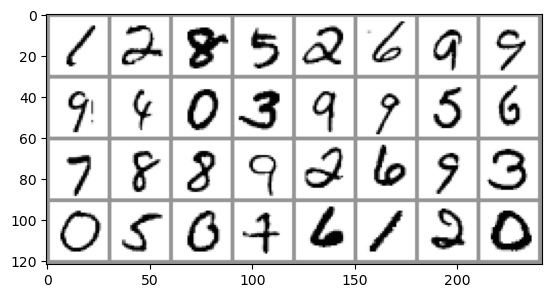

In [9]:
# plot a batch of images

dataiter = iter(training_loader)
images, labels = next(dataiter)

# Create a grid from the images and show them
img_grid = torchvision.utils.make_grid(images)
matplotlib_imshow(img_grid, one_channel=True)
print('  '.join(classes[labels[j]] for j in range(4)))

<a name="5"></a>
## <font color='blue'> 5. Model </font>

In [12]:
class MNISTModel(nn.Module):
    def __init__(self):
        super(MNISTModel, self).__init__()
        self.fc1 = nn.Linear(28*28, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = x.view(-1, 28*28)  # Flatten the input
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)  # No softmax needed for logits (handled in loss function)
        return x

In [13]:
model = MNISTModel()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

<a name="6"></a>
## <font color='blue'> 6. Training </font>

We'll start with a basic training loop and progressively add features like validation metrics, custom metrics, and progress tracking with tqdm.

In the following figure you can see the basic steps for training:

<br>


<img src="images/Training_Loop.png"/>


<a name="6.1"></a>
### <font color='#1f618d'> 6.1. Basic Training </font>

In [19]:
# train for one epoch
def train(model, train_loader, criterion, optimizer):
    model.train()  # Set the model to training mode
    running_loss = 0.0  # Track the cumulative loss
    
    for i, data in enumerate(train_loader):  # Iterate through the data batches
        inputs, labels = data  # Unpack the inputs and labels
        
        # Zero the gradients to avoid accumulation
        optimizer.zero_grad()  
        
        # Forward pass
        outputs = model(inputs)  
        
        # Compute the loss
        loss = criterion(outputs, labels) 
        
        # Backward pass (compute gradients)
        loss.backward()  
        
        # Update model parameters
        optimizer.step()  

        running_loss += loss.item()  # Accumulate the loss
        if i % 1000 == 999:  # Print loss every 1000 batches
            last_loss = running_loss / 1000  # Average loss for the last 1000 batches
            print('  batch {} loss: {}'.format(i + 1, last_loss))
            running_loss = 0.0  # Reset the running loss


In the previous code:

**running_loss** accumulates the loss per batch as the loop iterates.

The key detail is that running_loss is continuously summed across batches. Every 1000 batches, it's averaged to compute last_loss, which represents the average loss over those 1000 batches.

So:

- loss.item() → Loss for the current batch
- running_loss → Accumulates batch losses
- last_loss → Average loss for the last 1000 batches

In [15]:
# Let's train
for epoch in range(2):
     train(model, training_loader, criterion, optimizer)

  batch 1000 loss: 0.47203147077932955
  batch 1000 loss: 0.18617938501760364


We can combine both loops in one function:

In [16]:
model = MNISTModel()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [17]:
# train
def train(model, train_loader, criterion, optimizer, epochs=2):
    
    for epoch in range(epochs):  
        
        model.train()  # Set the model to training mode
        running_loss = 0.0  # Track the cumulative loss

        for i, data in enumerate(train_loader):  # Iterate through the data batches
            inputs, labels = data  # Unpack the inputs and labels

            optimizer.zero_grad()  # Zero the gradients to avoid accumulation
            outputs = model(inputs)  # Forward pass
            loss = criterion(outputs, labels)  # Compute the loss
            loss.backward()  # Backward pass (compute gradients)
            optimizer.step()  # Update model parameters

            running_loss += loss.item()  # Accumulate the loss
            if i % 1000 == 999:  # Print loss every 1000 batches
                last_loss = running_loss / 1000  # Average loss for the last 1000 batches
                print('  batch {} loss: {}'.format(i + 1, last_loss))
                running_loss = 0.0  # Reset the running loss

In [18]:
train(model, training_loader, criterion, optimizer, epochs=2)

  batch 1000 loss: 0.45758966579660776
  batch 1000 loss: 0.1786948857726529


<a name="6.2"></a>
### <font color='#1f618d'> 6.2. Including a progress bar </font>

In [20]:
model = MNISTModel()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [21]:
from tqdm import tqdm  # Import tqdm for the progress bar


def train(model, train_loader, criterion, optimizer, epochs=2):
    
    for epoch in range(epochs):  
        
        model.train()  # Set the model to training mode
        running_loss = 0.0  # Track the cumulative loss

        # Wrap train_loader with tqdm to show progress
        for i, data in enumerate(tqdm(train_loader, desc=f"Epoch {epoch + 1} Progress")):
            inputs, labels = data  # Unpack the inputs and labels

            optimizer.zero_grad()  # Zero the gradients to avoid accumulation
            outputs = model(inputs)  # Forward pass
            loss = criterion(outputs, labels)  # Compute the loss
            loss.backward()  # Backward pass (compute gradients)
            optimizer.step()  # Update model parameters

            running_loss += loss.item()  # Accumulate the loss
            if i % 1000 == 999:  # Print loss every 1000 batches
                last_loss = running_loss / 1000  # Average loss for the last 1000 batches
                print('  batch {} loss: {}'.format(i + 1, last_loss))
                running_loss = 0.0  # Reset the running loss
                

train(model, training_loader, criterion, optimizer, epochs=2)


Epoch 1 Progress:  55%|███████████████████████████████████████████                                    | 1023/1875 [00:08<00:07, 118.80it/s]

  batch 1000 loss: 0.4323185588642955


Epoch 2 Progress:  54%|██████████████████████████████████████████▋                                    | 1014/1875 [00:08<00:07, 116.69it/s]

  batch 1000 loss: 0.17033670120500027


Epoch 2 Progress: 100%|███████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:16<00:00, 114.60it/s]


<a name="6.3"></a>
### <font color='#1f618d'> 6.3. Including a validation set </font>

In [22]:
model = MNISTModel()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

Epoch 1 - Train Loss: 0.3512, Train Acc: 89.46%, Val Loss: 0.1997, Val Acc: 93.69%
Epoch 2 - Train Loss: 0.1720, Train Acc: 94.73%, Val Loss: 0.1322, Val Acc: 95.83%
Epoch 3 - Train Loss: 0.1290, Train Acc: 96.02%, Val Loss: 0.1189, Val Acc: 96.34%
Epoch 4 - Train Loss: 0.1065, Train Acc: 96.63%, Val Loss: 0.1096, Val Acc: 96.75%
Epoch 5 - Train Loss: 0.0908, Train Acc: 97.12%, Val Loss: 0.1115, Val Acc: 96.50%


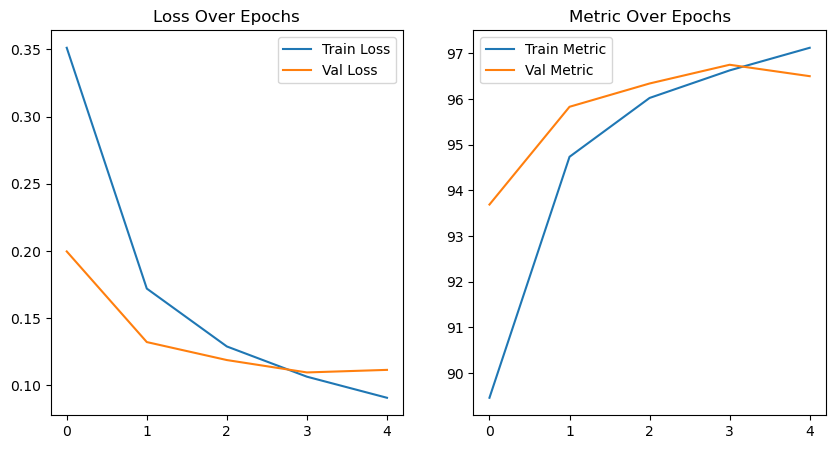

In [23]:
# Training setup
def train(model, train_loader, val_loader, criterion, optimizer, epochs=10):
    train_losses, val_losses = [], []  # Track training and validation losses
    train_acc, val_acc = [], []        # Track training and validation accuracy

    for epoch in range(epochs):  
        model.train()  # Set model to training mode
        running_loss = 0.0  # Track cumulative training loss
        correct, total = 0, 0  # Track correct predictions and total samples

        # Training loop
        for i, data in enumerate(train_loader):  
            inputs, labels = data  # Unpack inputs and labels

            optimizer.zero_grad()  # Zero gradients to prevent accumulation
            outputs = model(inputs)  # Forward pass
            loss = criterion(outputs, labels)  # Compute loss
            loss.backward()  # Backward pass (compute gradients)
            optimizer.step()  # Update model parameters

            running_loss += loss.item()  # Accumulate batch losses
            _, predicted = torch.max(outputs, 1)  # Get predicted class
            total += labels.size(0)  # Update total sample count
            correct += (predicted == labels).sum().item()  # Count correct predictions

        avg_loss = running_loss / len(train_loader)  # Average loss per batch
        avg_acc = 100 * correct / total  # Average accuracy
        train_losses.append(avg_loss)  # Store training loss
        train_acc.append(avg_acc)      # Store training accuracy

        # Validation phase
        model.eval()  # Set model to evaluation mode
        running_vloss = 0.0  # Track cumulative validation loss
        correct, total = 0, 0  # Reset correct and total counts for validation

        with torch.no_grad():  # Disable gradient computation during validation
            for data in val_loader:  
                inputs, labels = data
                outputs = model(inputs)
                vloss = criterion(outputs, labels)  # Compute validation loss
                running_vloss += vloss.item()  # Accumulate batch losses

                _, predicted = torch.max(outputs, 1)  # Get predicted class
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        avg_vloss = running_vloss / len(val_loader)  # Average validation loss per batch
        avg_vacc = 100 * correct / total  # Average validation accuracy
        val_losses.append(avg_vloss)  # Store validation loss
        val_acc.append(avg_vacc)      # Store validation accuracy

        # Print epoch summary
        print(f'Epoch {epoch + 1} - Train Loss: {avg_loss:.4f}, Train Acc: {avg_acc:.2f}%, '
              f'Val Loss: {avg_vloss:.4f}, Val Acc: {avg_vacc:.2f}%')

    # Plotting
    metrics = {'train_loss': train_losses, 'val_loss': val_losses, 
               'train_metric': train_acc, 'val_metric': val_acc}
    plot_metrics(metrics)



# Example training loop
train(model, training_loader, validation_loader, criterion, optimizer, epochs=5)


Note that for validation, we set the model to evaluation mode (model.eval()). This is crucial for models that behave differently during training and inference, such as those with dropout or batch normalization (e.g., dropout is disabled, and batch normalization uses running statistics instead of batch statistics).

Remember that in the previous code:

- **`running_loss`**:  
  Tracks the **cumulative loss** during the epoch. Each batch's loss is added to it.  

- **`avg_loss`**:  
  Represents the **average loss per batch** for the entire epoch.  
  Calculated as:  

$$
\text{avg_loss} = \frac{\text{running_loss}}{\text{len(train_loader)}}
$$

`running_loss` keeps a running total, while `avg_loss` normalizes it to provide a meaningful metric for model performance.


**running_vloss** accumulates the batch losses during the validation phase for a single epoch. Since it resets at the start of each epoch, dividing it by the number of batches gives the average validation loss for that epoch.

<a name="6.4"></a>
### <font color='#1f618d'> 6.4. Adding a custom metric </font>

In [24]:
model = MNISTModel()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [25]:
# accuracy
def accuracy(outputs, labels):
    _, predicted = torch.max(outputs, 1)
    return (predicted == labels).sum() / labels.size(0)

In [26]:
# Training setup
def train(model, train_loader, val_loader, criterion, optimizer, epochs=10, metric_fn=None):
    metrics = {'train_loss': [], 'val_loss': [], 'train_metric': [], 'val_metric': []}  # Tracking metrics

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0  # Tracks cumulative training loss for the epoch
        metric_value, total = 0, 0  # Tracks custom metric and sample count

        # Training phase
        for data in train_loader:
            inputs, labels = data

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()  # Accumulate loss
            if metric_fn:  # Custom metric calculation
                metric_value += metric_fn(outputs, labels).item()  # Accumulate custom metric values
            total += labels.size(0)

        avg_loss = running_loss / len(train_loader)  # Average loss for the epoch
        avg_metric = metric_value / len(train_loader) if metric_fn else 0  # Average custom metric
        metrics['train_loss'].append(avg_loss)
        metrics['train_metric'].append(avg_metric)  # Store custom metric for training

        
        # Validation phase
        model.eval()
        running_vloss = 0.0  # Tracks cumulative validation loss
        metric_value, total = 0, 0  # Reset custom metric for validation
        with torch.no_grad():  # No gradients needed in validation
            
            for data in val_loader:
                inputs, labels = data
                outputs = model(inputs)
                vloss = criterion(outputs, labels)
                running_vloss += vloss.item()  # Accumulate validation loss

                if metric_fn:  # Custom metric calculation in validation
                    metric_value += metric_fn(outputs, labels).item()
                total += labels.size(0)

        avg_vloss = running_vloss / len(val_loader)  # Average validation loss
        avg_vmetric = metric_value / len(val_loader) if metric_fn else 0  # Average custom metric
        metrics['val_loss'].append(avg_vloss)
        metrics['val_metric'].append(avg_vmetric)  # Store custom metric for validation

        # Display results per epoch
        print(f'Epoch {epoch + 1} - Train Loss: {avg_loss:.4f}, Train Metric: {avg_metric:.4f}, '
              f'Val Loss: {avg_vloss:.4f}, Val Metric: {avg_vmetric:.4f}')

    return metrics


In [27]:
metrics = train(model, training_loader, validation_loader, criterion, optimizer, epochs=5, metric_fn=accuracy)

Epoch 1 - Train Loss: 0.3478, Train Metric: 0.8955, Val Loss: 0.2088, Val Metric: 0.9326
Epoch 2 - Train Loss: 0.1705, Train Metric: 0.9480, Val Loss: 0.1378, Val Metric: 0.9585
Epoch 3 - Train Loss: 0.1267, Train Metric: 0.9607, Val Loss: 0.1127, Val Metric: 0.9655
Epoch 4 - Train Loss: 0.1060, Train Metric: 0.9664, Val Loss: 0.1108, Val Metric: 0.9650
Epoch 5 - Train Loss: 0.0918, Train Metric: 0.9714, Val Loss: 0.1120, Val Metric: 0.9679


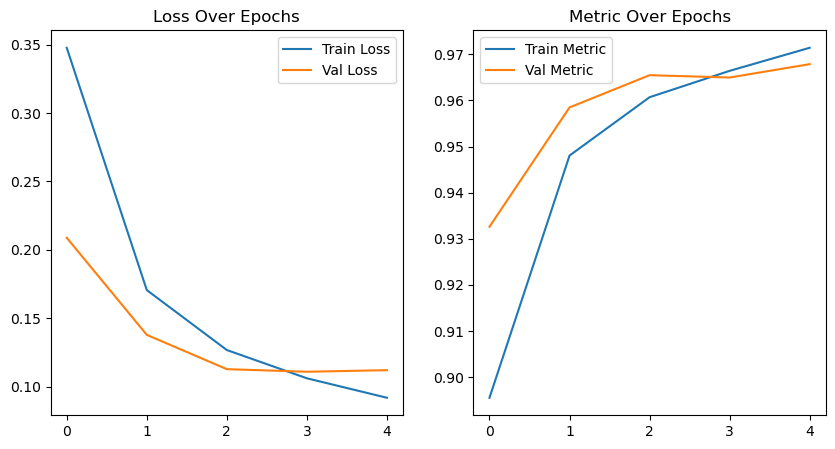

In [28]:
plot_metrics(metrics)

**Note:** The metric is averaged at the end of each epoch, by dividing the sum of the metric by the length of the loader. However, it could be better to average the metric during each batch, and then average the batch averages at the end of the epoch. This is because the last batch could be smaller than the other batches, and this could cause a slight bias in the metric. In order to do this, the total amount of samples processed should be tracked, and used to calculate the average.

In [ ]:
#inside the training loop
if metric_fn:
    metric_value += metric_fn(outputs, labels).item() * labels.size(0)
total += labels.size(0)
#after the training loop
avg_metric = metric_value / total if metric_fn else 0

<a name="references"></a>
## <font color='blue'> References </font>

[PyTorch Documentation](https://pytorch.org/docs/stable/index.html)

[IBM Deep Learning with PyTorch](https://www.coursera.org/learn/advanced-deep-learning-with-pytorch?specialization=ibm-deep-learning-with-pytorch-keras-tensorflow)
